<a href="https://colab.research.google.com/github/ashahdeen/MAIZE-CROP-DISEASE-IMAGE-CLASSIFICATION/blob/dev-branch/Model_interpretability_with_Captum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting colab to drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading libraries**

In [ ]:
%%capture
pip install captum


In [ ]:
%%capture
pip install fastai --upgrade

In [ ]:
#nstall the HuggingFace's transformers repository.
%%capture

!pip install -q git+https://github.com/huggingface/transformers

from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

from fastai.vision.all import *

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
#loading data
path='/content/drive/MyDrive/MOG/DATA/Datasets/Augment Images/test'
imgs = get_image_files(path)

def gray(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, imgs, valid_pct=0.2, seed=42,
    label_func=gray, item_tfms=Resize(224))

In [ ]:
#fine tune the path on a pretrained model.

learn = cnn_learner(dls, resnet34, metrics=error_rate)


In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.369980,0.287003,0.111111,00:46


epoch,train_loss,valid_loss,error_rate,time
0,1.206664,0.381541,0.138889,01:03
1,1.210881,0.473185,0.138889,01:03
2,1.186430,0.435502,0.111111,01:03
3,1.138852,0.552920,0.305556,01:04
4,1.109339,0.648381,0.333333,01:03


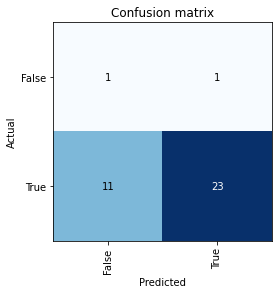

In [ ]:
#interpratation of the model predicted classes vs the actual.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

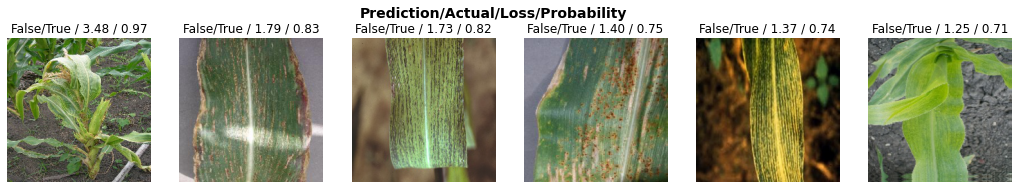

In [ ]:
#Visualize top losses
interp.plot_top_losses(6, nrows=1)

In [ ]:
#storing the fine tuned model
learn.export('captum.pt')
learn_inf = load_learner('/content/drive/MyDrive/we dont/captum.pt')

In [ ]:
#selecting a random image
idx = random.randint(0, len(imgs))

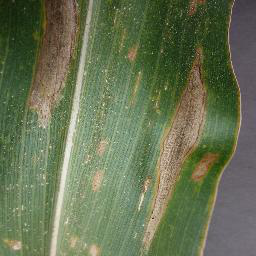

In [ ]:
#plotting the random image selected
image = PILImage.create(imgs[idx])
image

In [ ]:
image = learn_inf.dls.after_item(image)
image = learn_inf.dls.after_batch(image)

In [ ]:
#the prediction of the random image and the probability of the prediction.
pred,pred_idx,probs = learn_inf.predict(imgs[idx])
pred, pred_idx, probs

('False', tensor(0), tensor([0.9550, 0.0450]))

####Model Interpretability with captum.

Captum IntegratedGradients to compute the attributions using Integrated Gradients and visualize them on the target image

In [86]:
#IntegratedGradients feature attribution .
integrated_gradients = IntegratedGradients(learn_inf.model)
attr_ig = integrated_gradients.attribute(image, target=pred_idx, n_steps=200)

In [87]:
transposed_attr_ig = np.transpose(attr_ig.squeeze().numpy(), (1,2,0))
transposed_image = np.transpose(image.squeeze().numpy(), (1,2,0))

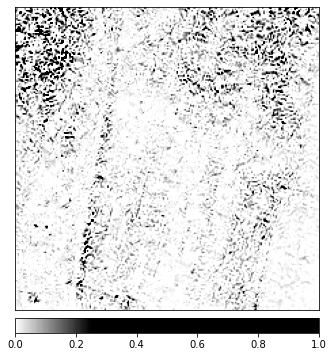

In [88]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(transposed_attr_ig,
                             transposed_image,
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


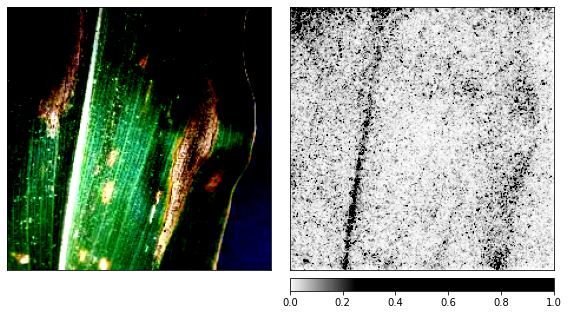

In [89]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(image,nt_type='smoothgrad_sq', target=pred_idx)
transposed_attr_ig_nt = np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0))
_ = viz.visualize_image_attr_multiple(transposed_attr_ig_nt,
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Occlusion based attriution

In [ ]:
occlusion = Occlusion(learn_inf.model)

attr_occ = occlusion.attribute(image,
                               strides = (3, 8, 8),
                               target=pred_idx,
                               sliding_window_shapes=(3,15, 15),
                               baselines=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


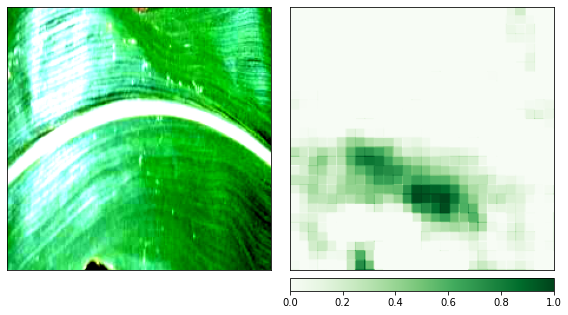

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.squeeze().numpy(), (1,2,0)),
                                      transposed_image,
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

different window shape

In [ ]:
# occlusion = Occlusion(learn_inf.model)

# attr_occ = occlusion.attribute(image,
#                                strides = (3, 50, 50),
#                                target=pred_idx,
#                                sliding_window_shapes=(3,60, 60),
#                                baselines=0)

# _ = viz.visualize_image_attr_multiple(np.transpose(attr_occ.squeeze().numpy(), (1,2,0)),
#                                       transposed_image,
#                                       ["original_image", "heat_map"],
#                                       ["all", "positive"],
#                                       show_colorbar=True,
#                                       outlier_perc=2,
#                                      )

##Using vision transformers model

In [ ]:
#importing libraries.
import torch

import numpy as np

from captum.attr import IntegratedGradients
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

In [ ]:
%%capture
pip install transformers

In [ ]:
import transformers

In [ ]:
#model class

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=6):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)
        return logits

In [ ]:
  # loss = None
  #       if labels is not None:
  #         loss_fct = nn.CrossEntropyLoss()
  #         loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
  #       if loss is not None:
  #         return logits, loss.item()
  #       else:

In [ ]:
# #model class

# class ViTForImageClassification(nn.Module):
#     def __init__(self, num_labels=6):
#         super(ViTForImageClassification, self).__init__()
#         self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
#         self.dropout = nn.Dropout(0.1)
#         self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
#         self.num_labels = num_labels

#     def forward(self, pixel_values):
#         outputs = self.vit(pixel_values=pixel_values)
#         output = self.dropout(outputs.last_hidden_state[:,0])
#         logits = self.classifier(output)

#         loss = None
#         if labels is not None:
#           loss_fct = nn.CrossEntropyLoss()
#           loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
#         if loss is not None:
#           return logits, loss.item()
#         else:
#           return logits, None

In [ ]:
# from transformers import ViTFeatureExtractor, ViTForImageClassification
# from PIL import Image
# import requests

# # url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# # image = Image.open(requests.get(url, stream=True).raw)

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# inputs = feature_extractor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
#connecting to CPU 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [ ]:
#loading model path
MODEL_PATH = '/content/drive/MyDrive/MOG/ViT_adjusted.pt'
model = torch.load(MODEL_PATH,map_location=torch.device('cpu'))
model.eval()

In [ ]:
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 3)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(3, 2)
 
        self.lin1.weight = nn.Parameter(torch.arange(0.0, 9.0).view(3, 3))
        self.lin1.bias = nn.Parameter(torch.zeros(1,3))
        self.lin2.weight = nn.Parameter(torch.arange(0.0, 6.0).view(2, 3))
        self.lin2.bias = nn.Parameter(torch.ones(1,2))

    def forward(self, input):
        return self.lin2(self.relu(self.lin1(input)))

In [ ]:
#feature attribution with IntegratedGradients
np.random.seed(123)
torch.manual_seed(123)

# input = torch.rand(2, 3)
input = torch.tensor([3.0],requires_grad=True)
baseline = torch.tensor([0.0])
ig = IntegratedGradients(model)
num_labels=6
attributions, approximation_error = ig.attribute(input,
                                                 baselines = baseline,
                                                 method='gausslegendre',
                                                 return_convergence_delta=True)
                                                

In [ ]:
 def __init__(self):
        super().__init__()

 def forward(self, input1, input2):
        relu_out1 = F.relu(input1)
        relu_out2 = F.relu(input2)
        return F.relu(relu_out1 - 1 - relu_out2)
# defining model input tensors
input1 = torch.tensor([3.0], requires_grad=True)
input2 = torch.tensor([1.0], requires_grad=True)

# defining baselines for each input tensor
baseline1 = torch.tensor([0.0])
baseline2 = torch.tensor([0.0])

# defining and applying integrated gradients on ToyModel and the
ig = IntegratedGradients(model)
attributions, approximation_error = ig.attribute((input1, input2),
                                                 baselines=(baseline1, baseline2),
                                                 method='gausslegendre',
                                                 return_convergence_delta=True)

TypeError: ignored

In [ ]:
integrated_gradients = IntegratedGradients(learn_inf.model)
attr_ig = integrated_gradients.attribute(image, target=pred_idx, n_steps=200)

In [ ]:


ig = IntegratedGradients(model)
attributions = ig.attribute(input, target=0)

In [ ]:
  def __init__(self):
        super().__init__()

  def forward(self, input1, input2):
        relu_out1 = F.relu(input1)
        relu_out2 = F.relu(input2)
        return F.relu(relu_out1 - 1 - relu_out2)

occlusion for this

In [ ]:
occlusion = Occlusion(model)

strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
target=208,                       # Labrador index in ImageNet
sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
baselines = 0                     # values to occlude the image with. 0 corresponds to gray

attribution_dog = occlusion.attribute(input,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)


target=283,                       # Persian cat index in ImageNet
attribution_cat = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=0)

In [ ]:
from typing import Any, Callable, List, Tuple, Union

import torch
import torch.nn.functional as F
from captum._utils.common import (
    _format_additional_forward_args,
    _format_input,
    _format_output,
)
from captum._utils.gradient import compute_layer_gradients_and_eval
from captum._utils.typing import TargetType
from captum.attr._utils.attribution import GradientAttribution, LayerAttribution
from captum.log import log_usage
from torch import Tensor
from torch.nn import Module


In [ ]:
#
class LayerGradCam(LayerAttribution, GradientAttribution):
    def __init__(
        self,
        forward_func: Callable,
        layer: Module,
        device_ids: Union[None, List[int]] = None,
    ) -> None:

        LayerAttribution.__init__(self, forward_func, layer, device_ids)
        GradientAttribution.__init__(self, forward_func)
 
    def attribute(
        self,
        inputs: Union[Tensor, Tuple[Tensor, ...]],
        target: TargetType = None,
        additional_forward_args: Any = None,
        attribute_to_layer_input: bool = False,
        relu_attributions: bool = False,
    ) -> Union[Tensor, Tuple[Tensor, ...]]:
      
        inputs = _format_input(inputs)
        additional_forward_args = _format_additional_forward_args(
        additional_forward_args
        )

        layer_gradients, layer_evals = compute_layer_gradients_and_eval(
            self.forward_func,
            self.layer,
            inputs,
            target,
            additional_forward_args,
            device_ids=self.device_ids,
            attribute_to_layer_input=attribute_to_layer_input,
        )

        summed_grads = tuple(
            torch.mean(
                layer_grad,
                dim=tuple(x for x in range(2, len(layer_grad.shape))),
                keepdim=True,
            )
            if len(layer_grad.shape) > 2
            else layer_grad
            for layer_grad in layer_gradients
        )

        scaled_acts = tuple(
            torch.sum(summed_grad * layer_eval, dim=1, keepdim=True)
            for summed_grad, layer_eval in zip(summed_grads, layer_evals)
        )
        if relu_attributions:
            scaled_acts = tuple(F.relu(scaled_act) for scaled_act in scaled_acts)
        return _format_output(len(scaled_acts) > 1, scaled_acts)


In [ ]:

input = torch.randn(2, 6, 224, 224, requires_grad=True)

ig = IntegratedGradients(model)
num_labels=6
attributions, approximation_error = ig.attribute(input,
                                                 baselines = baseline,
                                                 method='gausslegendre',
                                                 return_convergence_delta=True)

net =image
layer_gc = LayerGradCam(net, net.conv4)
input = torch.randn(2, 6, 224, 224, requires_grad=True)
attr = layer_gc.attribute(input, 6)
upsampled_attr = LayerAttribution.interpolate(attr, (224, 224))

In [ ]:
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 3)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(3, 2)
 
        self.lin1.weight = nn.Parameter(torch.arange(0.0, 9.0).view(3, 3))
        self.lin1.bias = nn.Parameter(torch.zeros(1,3))
        self.lin2.weight = nn.Parameter(torch.arange(0.0, 6.0).view(2, 3))
        self.lin2.bias = nn.Parameter(torch.ones(1,2))

    def forward(self, input):
        return self.lin2(self.relu(self.lin1(input)))

In [ ]:
net =LayerGradCam(model,layer)
layer_gc = LayerGradCam(net, net.conv4)
input = torch.randn(2, 6, 224, 224, requires_grad=True)
attr = layer_gc.attribute(input, 6)
upsampled_attr = LayerAttribution.interpolate(attr, (224, 224))

NameError: ignored

In [ ]:
#feature attribution with IntegratedGradients
np.random.seed(123)
torch.manual_seed(123)

# input = torch.rand(2, 3)
# input = torch.tensor([3.0],requires_grad=True)
# baseline = torch.tensor([0.0])
ig = IntegratedGradients(model)
num_labels=6
attributions, approximation_error = ig.attribute(inputs,
                                                 method='gausslegendre',
                                                 return_convergence_delta=True)
                                                

NameError: ignored